Importing Required Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import xgboost as xgb

Data Sourcing

In [48]:
train_df= pd.read_parquet(f'D:\\OneDrive\\Documents\\Skill up\\LLM\\nk-iv-prediction\\train_data.parquet')
test_df = pd.read_parquet(f'D:\\OneDrive\\Documents\\Skill up\\LLM\\nk-iv-prediction\\test_data.parquet')

Data Cleaing

In [49]:
train_df=train_df.dropna()
test_df = test_df.dropna()
train_df['call_iv_26000']=train_df.loc[: ,'call_iv_23500':'call_iv_25900'].mean(axis=1)
train_df=train_df.drop('expiry',axis=1)
features=train_df.loc[:, 'X0':'X41']

scaler=StandardScaler()
features_scaled_ary=scaler.fit_transform(features)
features_scaled=pd.DataFrame(features_scaled_ary,columns=features.columns,index=features.index)

pca=PCA(n_components=None)
pca.fit(features)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

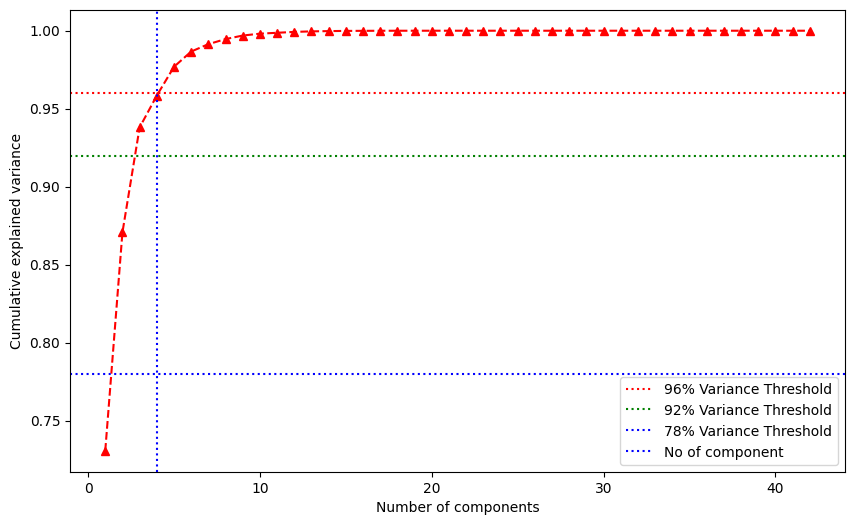

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='^', linestyle='--',color='red')
plt.axhline(y=0.96, color='r', linestyle=':', label='96% Variance Threshold')
plt.axhline(y=0.92, color='g', linestyle=':', label='92% Variance Threshold')
plt.axhline(y=0.78, color='b', linestyle=':', label='78% Variance Threshold')
plt.axvline(x=4, color='b', linestyle=':', label='No of component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend()

In [52]:
pca=PCA(n_components=4) #Retains 96% of total variability
feature_2d=pca.fit_transform(features)
feature_df=pd.DataFrame(data=feature_2d,columns=['X0','X1','X2','X3'])

Model Selection and Training

In [53]:
gb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

underlying=pd.DataFrame(train_df['underlying'])

call_iv_value=[]
for s in train_df.columns.tolist()[2:28]:
    call_part=s.split('_')
    call_number_str=call_part[-1]
    call_iv_value.append(int(call_number_str))
call_iv_value=pd.DataFrame(call_iv_value,columns=['Call Strike Value'])

call_test_iv_value=[]
for s in test_df.columns.tolist()[2:28]:
    call_part=s.split('_')
    call_number_str=call_part[-1]
    call_test_iv_value.append(int(call_number_str))
call_test_iv_value=pd.DataFrame(call_test_iv_value,columns=['Call Strike Value'])

call_outPut=train_df.loc[:,'call_iv_23500':'call_iv_26000']


put_iv_value=[]
for s in train_df.columns.tolist()[28:54]:
    put_part=s.split('_')
    put_number_str=put_part[-1]
    put_iv_value.append(int(put_number_str))
put_iv_value=pd.DataFrame(put_iv_value,columns=['Put Strike Value'])

put_test_iv_value=[]
for s in test_df.columns.tolist()[28:54]:
    put_part=s.split('_')
    put_number_str=put_part[-1]
    put_test_iv_value.append(int(put_number_str))
put_test_iv_value=pd.DataFrame(put_test_iv_value,columns=['Put Strike Value'])

put_outPut=train_df.loc[:,'put_iv_22500':'put_iv_25000']
final_Output=pd.DataFrame()

In [57]:
for i in range(train_df.shape[0]):
    underList=pd.DataFrame([underlying.iloc[i]]*len(call_iv_value),index=call_iv_value.index)
    featureList=pd.DataFrame([feature_df.loc[i, 'X0':'X3']]*len(call_iv_value),index=call_iv_value.index)

    call_y=pd.Series(call_outPut.iloc[i]).reset_index(drop=True)

    put_y=pd.Series(put_outPut.iloc[i]).reset_index(drop=True)

    call_final_trainSet=pd.concat([underList,featureList,call_iv_value],axis=1)

    gb_regressor.fit(call_final_trainSet,call_y)
    call_testSet=pd.concat([underList,featureList,call_test_iv_value],axis=1)

    call_y_pred=pd.DataFrame(gb_regressor.predict(call_testSet))

    put_final_trainSet=pd.concat([underList,featureList,put_iv_value],axis=1)
    gb_regressor.fit(put_final_trainSet,put_y)
    put_y_pred=pd.DataFrame(gb_regressor.predict(pd.concat([underList,featureList,put_test_iv_value],axis=1)))
    call_y_pred=call_y_pred.T
    put_y_pred=put_y_pred.T
    call_y_pred.columns=test_df.loc[:, 'call_iv_24000':'call_iv_26500'].columns.to_list()
    put_y_pred.columns=test_df.loc[:, 'put_iv_23000':'put_iv_25500'].columns.to_list()
    if i==0:
        final_Output=pd.concat([call_y_pred,put_y_pred],axis=1)
    else:
        final_Output=pd.concat([final_Output,pd.concat([call_y_pred,put_y_pred],axis=1)],axis=0,ignore_index=True)
    if i==12067:
        break
    print(final_Output.head())

   call_iv_24000  call_iv_24100  call_iv_24200  call_iv_24300  call_iv_24400  \
0       0.146550       0.141278       0.141278       0.143495       0.151266   
1       0.141687       0.134942       0.134942       0.135658       0.141569   
2       0.130497       0.125615       0.125615       0.128311       0.135972   
3       0.129794       0.125395       0.125395       0.128242       0.135805   
4       0.130588       0.126005       0.126005       0.128854       0.136691   

   call_iv_24500  call_iv_24600  call_iv_24700  call_iv_24800  call_iv_24900  \
0       0.162416       0.173260       0.184099       0.196703       0.209615   
1       0.152220       0.161420       0.171508       0.184324       0.197625   
2       0.148113       0.159056       0.171020       0.184268       0.198276   
3       0.148164       0.158939       0.170525       0.183622       0.197770   
4       0.149061       0.159599       0.171088       0.183468       0.196975   

   ...  put_iv_24600  put_iv_24700  pu